
# 2D ERT modelling and inversion


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.viewer.mpl import drawSensors

## Geometry definition
Create geometry definition for the modelling domain. ``worldMarker=True``
indicates the default boundary conditions for the ERT



(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

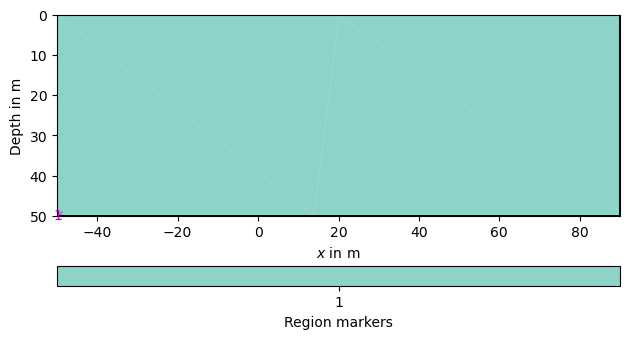

In [2]:
world = mt.createWorld(start=[-50, 0], end=[90, -50], marker=1, #layers=[-1, -5],
                       worldMarker=True)
pg.show(world)

Create some heterogeneous anomaly and merge them into a Piecewise Linear Complex (PLC)

(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

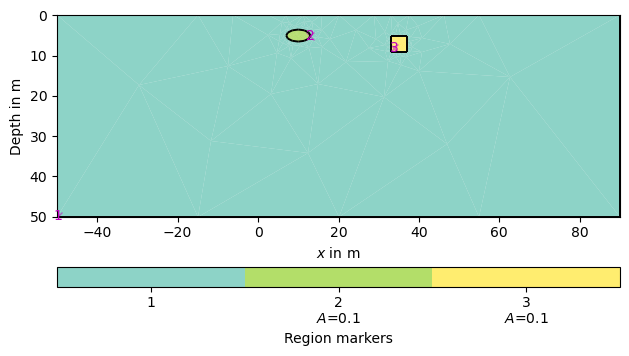

In [3]:
c = mt.createCircle(pos=[10, -5.], radius=[3, 1.5], marker=2, boundaryMarker=10, area=0.1)
r = mt.createRectangle(pos=[35, -7], size=[4.0, 4.0], marker=3, area=0.1)

geom = world + c + r
pg.show(geom)

## Synthetic data generation
Create a Dipole Dipole ('dd') measuring scheme with 48 electrodes.



In [4]:
n_elecs = 48
spacing = 1.0  # m
scheme = ert.createData(elecs=np.linspace(start=0, stop=(n_elecs*spacing)-spacing, num=n_elecs), schemeName='dd')

Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy.



(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

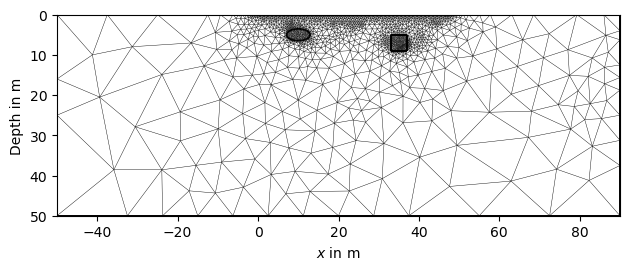

In [5]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)
pg.show(mesh)

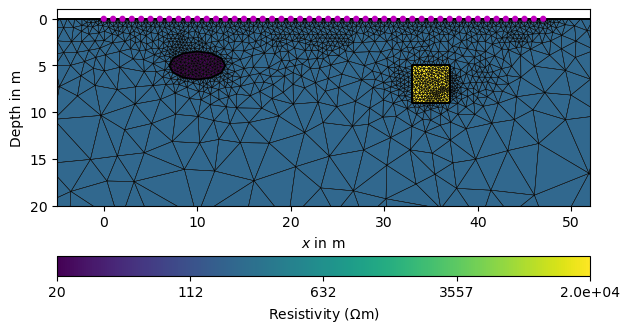

In [8]:
# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[1, 200.],
          [2, 20.],
          [3, 20000.],
         ]

# Take a look at the mesh and the resistivity distribution
fig, ax = pg.plt.subplots()
pg.show(mesh, ax=ax, data=rhomap, label=pg.unit('res'), showMesh=True, logScale=True)
drawSensors(ax, scheme.sensors(), diam=.5, color='m')
ax.set_ylim(-20,1)
ax.set_xlim(-5,47+5)
fig.tight_layout()
fig.savefig('../figures/fwdmodel2D.png', dpi=150, bbox_inches='tight')

Perform the modelling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 1% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [9]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

ModellingBase::setMesh() copying new mesh ... Found datafile: 48 electrodes
Found: 48 free-electrodes
rMin = 0.5, rMax = 94
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.0335874 s
FOP updating mesh dependencies ... 5.585e-06 s
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


29/08/25 - 18:06:18 - pyGIMLi - INFO - Data error estimate (min:max)  0.01000009393323961 : 0.011625865457318215
29/08/25 - 18:06:18 - pyGIMLi - INFO - 0.327974733105717 6294.559672538856
29/08/25 - 18:06:18 - pyGIMLi - INFO - Simulated data Data: Sensors: 48 data: 1035, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
29/08/25 - 18:06:18 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
29/08/25 - 18:06:18 - pyGIMLi - INFO - Simulated rhoa (min/max) 134.50428288296908 251.140934250215
29/08/25 - 18:06:18 - pyGIMLi - INFO - Selected data noise %(min/max) 1.000009393323961 1.1625865457318216


Calculating response for model: min = 20 max = 20000
Allocating memory for primary potential...... 0.00727971

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.325237s
Response: min = 136.203 max = 249.709 mean = 193.701
Reciprocity rms(modelReciprocity) 0.115533%, max: 0.64721%


Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



29/08/25 - 18:06:20 - pyGIMLi - INFO - Filtered rhoa (min/max) 134.50428288296908 251.140934250215


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x78a32c3bf8d0>)

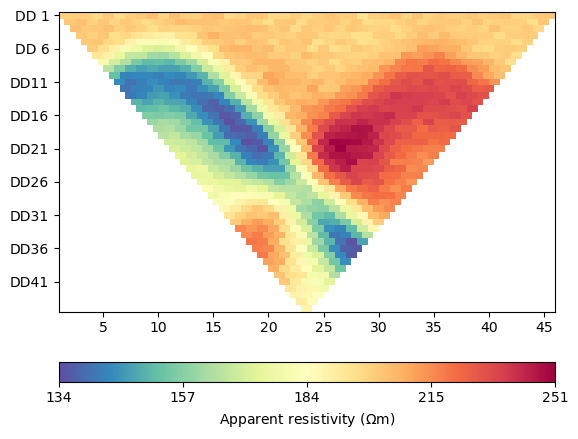

In [10]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('../data/dd48_fwd.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [11]:
mgr = ert.ERTManager('../data/dd48_fwd.dat')
inv = mgr.invert(lam=50, verbose=True)
#np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

29/08/25 - 18:06:23 - pyGIMLi - INFO - Found 2 regions.
29/08/25 - 18:06:23 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
29/08/25 - 18:06:23 - pyGIMLi - INFO - Found 2 regions.
29/08/25 - 18:06:23 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
29/08/25 - 18:06:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
29/08/25 - 18:06:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
29/08/25 - 18:06:23 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2222 Cells: 4164 Boundaries: 3262
29/08/25 - 18:06:23 - pyGIMLi - INFO - Use median(data values)=199.622783916353
29/08/25 - 18:06:23 - pyGIMLi - INFO - Created startmodel from forward operator:780, min/max=199.622784/199.622784
29/08/25 - 18:06:23 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  0

Statistics:

  Input vertices: 103
  Input segments: 104
  Input holes: 0

  Mesh vertices: 591
  Mesh triangles: 1041
  Mesh edges: 1631
  Mesh exterior boundary edges: 139
  Mesh interior boundary edges: 20
  Mesh subsegments (constrained edges): 159

min/max(dweight) = 86.0151/99.9991
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x78a327b722a0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 134/251
min/max (error): 1%/1.1

Run the inversion with the preset data. The Inversion mesh will be created
with default settings.



Let the ERTManger show you the model of the last successful run and how it
fits the data. Shows data, model response, and model.



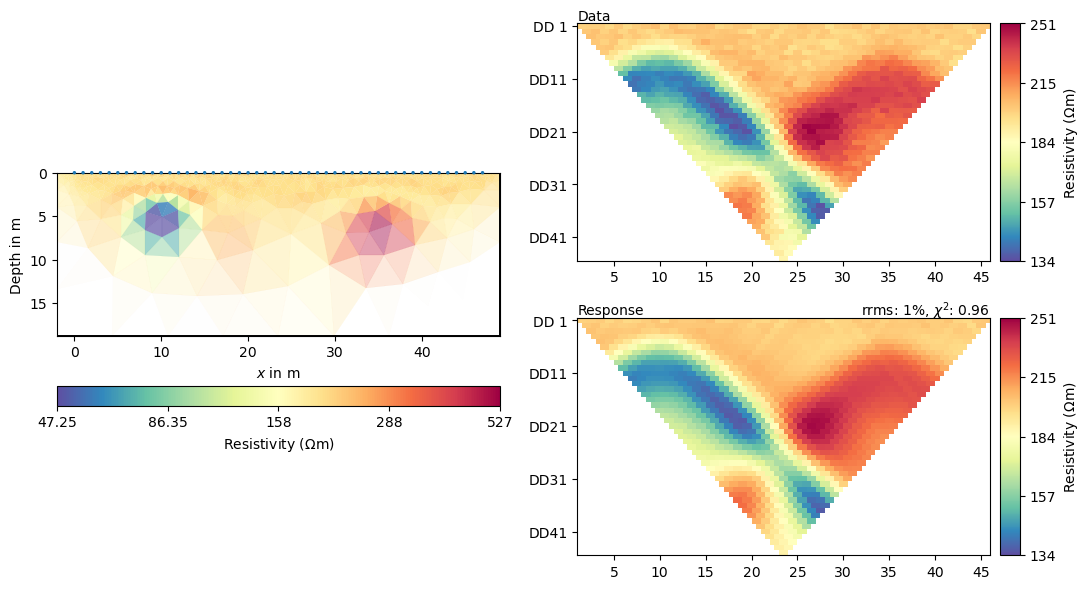

In [12]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

You can also provide your own mesh (e.g., a structured grid if you like them)
Note, that x and y coordinates needs to be in ascending order to ensure that
all the cells in the grid have the correct orientation, i.e., all cells need
to be numbered counter-clockwise and the boundary normal directions need to
point outside.



In [13]:
inversionDomain = pg.createGrid(x=np.linspace(start=0, stop=47*1, num=48),
                                y=-pg.cat([0], pg.utils.grange(0.5, 15, n=5))[::-1],
                                marker=2)

## Inversion with custom mesh
The inversion domain for ERT problems needs a boundary that represents the
far regions in the subsurface of the halfspace.
Give a cell marker lower than the marker for the inversion region, the lowest
cell marker in the mesh will be the inversion boundary region by default.



(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x78a325e50c90>)

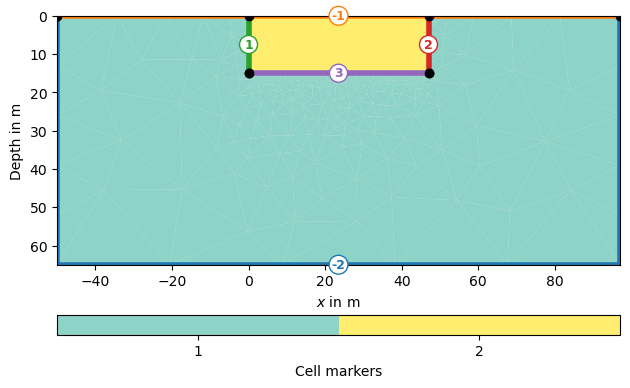

In [14]:
grid = pg.meshtools.appendTriangleBoundary(inversionDomain, marker=1,
                                           xbound=50, ybound=50)
pg.show(grid, markers=True)

Text(0.5, 0.98, 'Quadrupoles n :984')

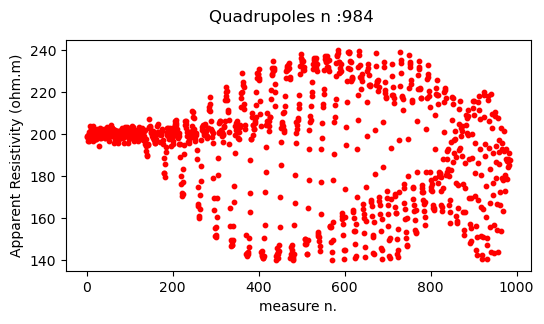

In [15]:
data.remove(data["rhoa"] <= 140)
data.remove(data["rhoa"] >= 240)
data.removeInvalid()
data.removeUnusedSensors()

# plot
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(np.arange(1, len(data['a']) + 1), data["rhoa"], color='red', s=10)
ax.set_ylabel('Apparent Resistivity (ohm.m)')
ax.set_xlabel('measure n.')
fig.suptitle(f'Quadrupoles n :{len(data["rhoa"])}')

The Inversion can be called with data and mesh as argument as well



In [16]:
model = mgr.invert(data, mesh=grid, lam=50, verbose=True)

29/08/25 - 18:06:39 - pyGIMLi - INFO - Found 2 regions.
29/08/25 - 18:06:39 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
29/08/25 - 18:06:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
29/08/25 - 18:06:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
29/08/25 - 18:06:39 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2035 Cells: 2980 Boundaries: 2544
29/08/25 - 18:06:39 - pyGIMLi - INFO - Use median(data values)=199.59382922490903
29/08/25 - 18:06:39 - pyGIMLi - INFO - Created startmodel from forward operator:235, min/max=199.593829/199.593829
29/08/25 - 18:06:39 - pyGIMLi - INFO - Starting inversion.


Found datafile: 48 electrodes
Found: 48 node-electrodes
Found non-Neumann domain
 updateDataDependency:: cleaning primpot
Reset region parameter
RegionManager copying mesh ...0.00447482 s 
create NeighborInfos ... 1.923e-05 s 
analysing mesh ... 2 regions.
creating para domain ... 0.00169912 s
creating para domain ... 0.00245197 s
ModellingBase::setMesh() copying new mesh ... Found datafile: 48 electrodes
Found: 48 free-electrodes
Found non-Neumann domain
0.0348812 s
FOP updating mesh dependencies ... 2.5606e-05 s
ModellingBase::setMesh() copying new mesh ... 0.016908 s
FOP updating mesh dependencies ... 2.1518e-05 s
min/max(dweight) = 86.0151/99.9991
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x78a327b722a0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 140/240
min/max (error): 1%/1.16%
min/max (start model): 200/200
---------------------------------------------------------

## Visualization
You can of course get access to mesh and model and plot them for your own.
Note that the cells of the parametric domain of your mesh might be in
a different order than the values in the model array if regions are used.
The manager can help to permutate them into the right order.



29/08/25 - 18:07:53 - pyGIMLi - INFO - Inversion stopped with chi² = 1.74


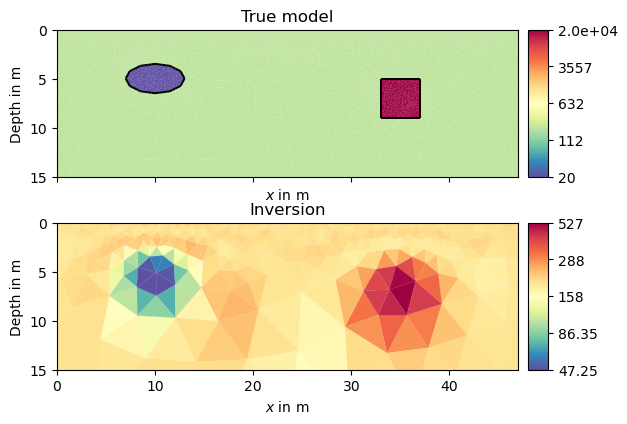

In [17]:
modelPD = mgr.paraModel(model)  # do the mapping
#pg.show(mgr.paraDomain, modelPD, label='Model', cMap='Spectral_r', logScale=True)

pg.info('Inversion stopped with chi² = {0:.3}'.format(mgr.fw.chi2()))

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(7,4.2))

pg.show(mesh, rhomap, ax=ax1, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", #cMin=20, cMax=400
       )
pg.show(meshPD, inv, ax=ax2, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", #cMin=20, cMax=400
       )
#mgr.showResult(ax=ax3, cMin=20, cMax=500,
               #orientation="vertical")

labels = ["True model", #"Inversion unstructured mesh", "Inversion regular grid"
         "Inversion"]
for ax, label in zip([ax1, ax2], labels):
    ax.set_xlim(mgr.paraDomain.xmin(), mgr.paraDomain.xmax())
    ax.set_ylim(mgr.paraDomain.ymin(), mgr.paraDomain.ymax())
    ax.set_title(label)

fig.savefig('../figures/2Dmodel.png', dpi=150, bbox_inches='tight', transparent=False)